# <font color='red'>**Sequence to sequence implementation**</font>

## Task -1: Simple Encoder and Decoder
Implement simple Encoder-Decoder model

In [ ]:
# Importing Necessary libraries
import warnings
warnings.filterwarnings("ignore")
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import tensorflow as tf

<font color='blue'>**Load the data**</font>

In [ ]:
# Downloading the data
!wget http://www.manythings.org/anki/ita-eng.zip

# Unzipping data file
!unzip /content/ita-eng.zip

--2022-08-02 03:20:18--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7782544 (7.4M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.42M  15.1MB/s    in 0.5s    

2022-08-02 03:20:19 (15.1 MB/s) - ‘ita-eng.zip’ saved [7782544/7782544]

Archive:  /content/ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


In [ ]:
# Downloading Glove vectors
!wget https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt

--2022-08-02 03:20:19--  https://www.dropbox.com/s/ddkmtqz01jc024u/glove.6B.100d.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ddkmtqz01jc024u/glove.6B.100d.txt [following]
--2022-08-02 03:20:20--  https://www.dropbox.com/s/raw/ddkmtqz01jc024u/glove.6B.100d.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccd77ab961b129b195ee3b29f03.dl.dropboxusercontent.com/cd/0/inline/BqOizBShEe1-RHS2xc6mzE82CjjBnOK1BvFEVirDKnfnFtPNTLWdau2K6XVL-JuzIaNujVPq-uxK4ymN-opGR2NmipcV7q8Kk0l59_zrJy0Qs9x74zuR7nP3dWXtGRe0hUVhLojhg478UCQSvO8-2L8L7MuQ5ikgG3bR-sxq5jW_SA/file# [following]
--2022-08-02 03:20:20--  https://uccd77ab961b129b195ee3b29f03.dl.dropboxusercontent.com/cd/0/inline/BqOizBShEe1-RHS2xc6mzE82CjjBnOK1BvFEVirDKnfnFtPNTLWda

In [ ]:
with open('/content/ita.txt', 'r') as txt_file:
    data_txt = txt_file.readlines()
print(data_txt[0:5])

['Hi.\tCiao!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #607364 (Cero)\n', 'Hi.\tCiao.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #4522287 (Guybrush88)\n', 'Run!\tCorri!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906347 (Guybrush88)\n', 'Run!\tCorra!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906348 (Guybrush88)\n', 'Run!\tCorrete!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #906350 (Guybrush88)\n']


In [ ]:
e = []
t = []
for s in data_txt:
    s = s.split('\t')
    e.append(s[0])
    t.append(s[1])

data = {'english': e, 'italian': t}
data = pd.DataFrame(data)
data.to_csv('ita_dataframe.csv', index=False)

In [ ]:
data.head()

,english,italian
0,Hi.,Ciao!
1,Hi.,Ciao.
2,Run!,Corri!
3,Run!,Corra!
4,Run!,Correte!


<font color='blue'>**Preprocess data**</font>

In [ ]:
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase

def preprocess(text):
    # convert all the text into lower letters
    # use this function to remove the contractions: https://gist.github.com/anandborad/d410a49a493b56dace4f814ab5325bbd
    # remove all the spacial characters: except space ' '
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text

def preprocess_ita(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    # we have found these characters after observing the data points, feel free to explore more and see if you can do find more
    # you are free to do more proprocessing
    # note that the model will learn better with better preprocessed data 
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[$)\?"’.°!;\'€%:,(/]', '', text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    return text


data['english'] = data['english'].apply(preprocess)
data['italian'] = data['italian'].apply(preprocess_ita)
data.head()

,english,italian
0,hi,ciao
1,hi,ciao
2,run,corri
3,run,corra
4,run,correte


In [ ]:
# Checking percentile values for lengths of italian and english sentences
ita_lens = data['italian'].str.split().apply(len)
eng_lens = data['english'].str.split().apply(len)

print("Italian sentences length percentiles: ")
print("-"*60)
for i in range(90,101):
    print(f"{i}th percentile of sentence length: {np.percentile(ita_lens, i)}")
print("\n")
for i in [99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]:
    print(f"{i}th percentile of sentence length: {np.percentile(ita_lens, i)}")

print("\n")
print("\n")

print("English sentences length percentiles: ")
print("-"*60)
for i in range(90,101):
    print(f"{i}th percentile of sentence length: {np.percentile(eng_lens, i)}")
print("\n")
for i in [99.1, 99.2, 99.3, 99.4, 99.5, 99.6, 99.7, 99.8, 99.9, 100]:
    print(f"{i}th percentile of sentence length: {np.percentile(eng_lens, i)}")

Italian sentences length percentiles: 
------------------------------------------------------------
90th percentile of sentence length: 8.0
91th percentile of sentence length: 8.0
92th percentile of sentence length: 8.0
93th percentile of sentence length: 9.0
94th percentile of sentence length: 9.0
95th percentile of sentence length: 9.0
96th percentile of sentence length: 9.0
97th percentile of sentence length: 10.0
98th percentile of sentence length: 11.0
99th percentile of sentence length: 12.0
100th percentile of sentence length: 92.0


99.1th percentile of sentence length: 12.0
99.2th percentile of sentence length: 12.0
99.3th percentile of sentence length: 13.0
99.4th percentile of sentence length: 13.0
99.5th percentile of sentence length: 13.0
99.6th percentile of sentence length: 14.0
99.7th percentile of sentence length: 15.0
99.8th percentile of sentence length: 16.0
99.9th percentile of sentence length: 22.0
100th percentile of sentence length: 92.0




English sentences le

**99.9% of Italian sentences have length less than 22 and 99.9% of English sentences have length less than 25 hence selecting sentences with length < 25**

In [ ]:
maxlen = 25

In [ ]:
print(f"Data shape before dropping sentences > 25 : {data.shape}")

data['ita_lens'] = data['italian'].str.split().apply(len)
data = data[data['ita_lens'] < 25]
data = data.drop(['ita_lens'], axis=1)

data['eng_lens'] = data['english'].str.split().apply(len)
data = data[data['eng_lens'] < 25]
data = data.drop(['eng_lens'], axis=1)

print(f"Data shape after dropping sentences > 25 : {data.shape}")

Data shape before dropping sentences > 25 : (354238, 2)
Data shape after dropping sentences > 25 : (353856, 2)


In [ ]:
# Adding special tokens <start> <end>
data['italian_inp'] = '<start> ' + data['italian'] + ' <end>'
data['english_inp'] = '<start> ' + data['english']
data['english_out'] = data['english'] + ' <end>'

data = data.drop(['english', 'italian'], axis=1)

In [ ]:
data.sample(5)

,italian_inp,english_inp,english_out
34905,<start> non disturbarmi <end>,<start> do not disturb me,do not disturb me <end>
79493,<start> è stato preso qualcosa <end>,<start> something was taken,something was taken <end>
221852,<start> tom non voleva andare in guerra <end>,<start> tom did not want to go to war,tom did not want to go to war <end>
338163,<start> tom è impegnato a preparare dei sandwi...,<start> tom is busy making sandwiches in the k...,tom is busy making sandwiches in the kitchen <...
328406,<start> quante persone sono venute allo zoo ie...,<start> how many people came to the zoo yesterday,how many people came to the zoo yesterday <end>


## Train - Test Split

In [ ]:
from sklearn.model_selection import train_test_split
train, validation = train_test_split(data, test_size=0.2, random_state=33)
print(f"Train shape: {train.shape}")
print(f"Validation shape: {validation.shape}")

Train shape: (283084, 3)
Validation shape: (70772, 3)


In [ ]:
# Adding token <end> for first entry in train english_inp so that our tokenizer
# could learn that word and we can use same tokenizer for both english_inp and english_out
train.iloc[0]['english_inp'] = str(train.iloc[0]['english_inp'])+' <end>'

In [ ]:
train.head(3)

,italian_inp,english_inp,english_out
151828,<start> io non ho amici <end>,<start> i do not have any friends <end>,i do not have any friends <end>
288603,<start> ricevetti una lettera dalla mia amica ...,<start> i received a letter from my friend,i received a letter from my friend <end>
127313,<start> tom è scherzoso <end>,<start> tom is being facetious,tom is being facetious <end>


In [ ]:
validation.head(3)

,italian_inp,english_inp,english_out
11067,<start> noi stiamo perdendo <end>,<start> we are losing,we are losing <end>
117475,<start> beve del tè verde <end>,<start> do you drink green tea,do you drink green tea <end>
137257,<start> ho dormito bene la notte scorsa <end>,<start> i slept well last night,i slept well last night <end>


In [ ]:
# Vectorizing texts using tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

ita_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
ita_tokenizer.fit_on_texts(train['italian_inp'].values)

eng_tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
eng_tokenizer.fit_on_texts(train['english_inp'].values)

In [ ]:
ita_vocab_len = len(ita_tokenizer.word_index.keys())
eng_vocab_len = len(eng_tokenizer.word_index.keys())

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
ita_inp = ita_tokenizer.texts_to_sequences(train['italian_inp'].values)
ita_inp = pad_sequences(ita_inp, maxlen=maxlen, padding='post')

eng_inp = eng_tokenizer.texts_to_sequences(train['english_inp'].values)
eng_inp = pad_sequences(eng_inp, maxlen=maxlen, padding='post')

eng_out = eng_tokenizer.texts_to_sequences(train['english_out'].values)
eng_out = pad_sequences(eng_out, maxlen=maxlen, padding='post')

In [ ]:
ita_inp_val = ita_tokenizer.texts_to_sequences(validation['italian_inp'].values)
ita_inp_val = pad_sequences(ita_inp_val, maxlen=maxlen, padding='post')

eng_inp_val = eng_tokenizer.texts_to_sequences(validation['english_inp'].values)
eng_inp_val = pad_sequences(eng_inp_val, maxlen=maxlen, padding='post')

eng_out_val = eng_tokenizer.texts_to_sequences(validation['english_out'].values)
eng_out_val = pad_sequences(eng_out_val, maxlen=maxlen, padding='post')

## <font color='blue'>**Implement custom encoder decoder model**</font>

In [ ]:
import os
def create_directories(model_name):
    if str(model_name) not in os.listdir():
        os.mkdir(model_name)
        os.mkdir(model_name+'/saved_models')
        os.mkdir(model_name+'/logs')
        print(f"saved_models, logs directories created for {model_name}")

<font color='blue'>**Encoder**</font>

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns encoder-outputs,
    encoder_final_state_h,encoder_final_state_c
    
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):
        
        super(Encoder, self).__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        #Initialize Embedding layer
        self.embedding_layer = Embedding(input_dim = self.inp_vocab_size,
                                         output_dim = self.embedding_size,
                                         input_length = self.input_length, trainable=True)
        
        #Intialize Encoder LSTM layer
        self.lstm_layer = LSTM(self.lstm_size, return_state=True, return_sequences=True)

        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0

    def call(self,input_sequence, states=None):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the 
          embedding layer ouput to encoder_lstm
          returns -- encoder_output, last time step's hidden and cell state
        '''
        input_emb = self.embedding_layer(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.lstm_layer(input_emb, states)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c
      

    
    def initialize_states(self, batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units],
        cell state zeros is of size [32,lstm_units]
        '''
        initial_h = tf.zeros(shape = (batch_size, self.lstm_size))
        initial_c = tf.zeros(shape = (batch_size, self.lstm_size))
        states = [initial_h, initial_c]
        return states


In [ ]:
class Decoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,out_vocab_size,embedding_size,lstm_size,input_length):
        
        super(Decoder, self).__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length
        #Initialize Embedding layer
        self.decoder_embedding = Embedding(input_dim = self.out_vocab_size,
                                           output_dim = self.embedding_size,
                                           input_length = self.input_length)
        #Intialize Decoder LSTM layer
        self.decoder_lstm = LSTM(self.lstm_size, return_sequences=True, return_state=True)
        #self.initial_states = 


    def call(self,input_sequence,initial_states=None):
        '''
        This function takes a sequence input and the initial states of the encoder.
        Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to decoder_lstm
        
        returns -- decoder_output,decoder_final_state_h,decoder_final_state_c
        '''

        decoder_emb = self.decoder_embedding(input_sequence)
        self.lstm_output, self.lstm_state_h, self.lstm_state_c = self.decoder_lstm(decoder_emb, initial_states)
        return self.lstm_output, self.lstm_state_h, self.lstm_state_c      


In [ ]:
class Encoder_decoder(tf.keras.Model):
    
    def __init__(self,*params):
        
        super(Encoder_decoder, self).__init__()
        #Create encoder object
        self.encoder = Encoder(ita_vocab_len+1, embedding_size=50, lstm_size=64,
                          input_length = 25)
        #Create decoder object
        self.decoder = Decoder(eng_vocab_len+1, embedding_size=100, lstm_size=64,
                          input_length=25)
        #Intialize Dense layer(out_vocab_size) with activation='softmax'
        self.dense = TimeDistributed(Dense(eng_vocab_len+1, activation='softmax'))

    
    def call(self, data):
        '''
        A. Pass the input sequence to Encoder layer -- Return encoder_output,encoder_final_state_h,encoder_final_state_c
        B. Pass the target sequence to Decoder layer with intial states as encoder_final_state_h,encoder_final_state_C
        C. Pass the decoder_outputs into Dense layer 
        
        Return decoder_outputs
        '''
        input, output = data[0], data[1]
        enc_op, enc_h, enc_c = self.encoder(input)
        dec_op, _, _ = self.decoder(output, [enc_h, enc_c]) 
        dense_op = self.dense(dec_op)
        return dense_op

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.9

create_directories('model_1')
save_path = '/content/model_1/saved_models/{epoch:02d}'
log_path = '/content/model_1/logs'

#Defining callbacks
lr = LearningRateScheduler(scheduler)
stopper = EarlyStopping(monitor='val_loss', patience=4, mode='min')
saver = ModelCheckpoint(save_path)
tb = TensorBoard(log_path)

saved_models, logs directories created for model_1


In [ ]:
#Create an object of encoder_decoder Model class, 
# Compile the model and fit the model

model = Encoder_decoder()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy')
hist = model.fit([ita_inp, eng_inp],eng_out, epochs=60, batch_size=32,
                 validation_data=([ita_inp_val, eng_inp_val],eng_out_val),
                 callbacks=[lr, stopper, saver, tb])

Epoch 1/60
8845/8847 [============================>.] - ETA: 0s - loss: 1.0589

8847/8847 [==============================] - 150s 16ms/step - loss: 1.0589 - val_loss: 0.7661 - lr: 0.0010
Epoch 2/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.6475

8847/8847 [==============================] - 141s 16ms/step - loss: 0.6475 - val_loss: 0.5640 - lr: 0.0010
Epoch 3/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.4855

8847/8847 [==============================] - 149s 17ms/step - loss: 0.4855 - val_loss: 0.4535 - lr: 0.0010
Epoch 4/60
8844/8847 [============================>.] - ETA: 0s - loss: 0.3859

8847/8847 [==============================] - 142s 16ms/step - loss: 0.3860 - val_loss: 0.3860 - lr: 0.0010
Epoch 5/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.3201

8847/8847 [==============================] - 142s 16ms/step - loss: 0.3201 - val_loss: 0.3413 - lr: 0.0010
Epoch 6/60
8844/8847 [============================>.] - ETA: 0s - loss: 0.2747

8847/8847 [==============================] - 142s 16ms/step - loss: 0.2747 - val_loss: 0.3099 - lr: 0.0010
Epoch 7/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.2419

8847/8847 [==============================] - 141s 16ms/step - loss: 0.2419 - val_loss: 0.2902 - lr: 0.0010
Epoch 8/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.2173

8847/8847 [==============================] - 142s 16ms/step - loss: 0.2173 - val_loss: 0.2736 - lr: 0.0010
Epoch 9/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1984

8847/8847 [==============================] - 142s 16ms/step - loss: 0.1984 - val_loss: 0.2640 - lr: 0.0010
Epoch 10/60
8844/8847 [============================>.] - ETA: 0s - loss: 0.1834

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1834 - val_loss: 0.2550 - lr: 0.0010
Epoch 11/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1712

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1712 - val_loss: 0.2486 - lr: 0.0010
Epoch 12/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1610

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1610 - val_loss: 0.2424 - lr: 0.0010
Epoch 13/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1524

8847/8847 [==============================] - 142s 16ms/step - loss: 0.1524 - val_loss: 0.2383 - lr: 0.0010
Epoch 14/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1451

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1451 - val_loss: 0.2347 - lr: 0.0010
Epoch 15/60
8843/8847 [============================>.] - ETA: 0s - loss: 0.1388

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1388 - val_loss: 0.2318 - lr: 0.0010
Epoch 16/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1333

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1333 - val_loss: 0.2318 - lr: 0.0010
Epoch 17/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1284

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1284 - val_loss: 0.2273 - lr: 0.0010
Epoch 18/60
8847/8847 [==============================] - ETA: 0s - loss: 0.1241

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1241 - val_loss: 0.2272 - lr: 0.0010
Epoch 19/60
8847/8847 [==============================] - ETA: 0s - loss: 0.1201

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1201 - val_loss: 0.2271 - lr: 0.0010
Epoch 20/60
8844/8847 [============================>.] - ETA: 0s - loss: 0.1166

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1166 - val_loss: 0.2245 - lr: 0.0010
Epoch 21/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1105

8847/8847 [==============================] - 141s 16ms/step - loss: 0.1105 - val_loss: 0.2231 - lr: 9.0000e-04
Epoch 22/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.1047

8847/8847 [==============================] - 142s 16ms/step - loss: 0.1047 - val_loss: 0.2207 - lr: 8.1000e-04
Epoch 23/60
8844/8847 [============================>.] - ETA: 0s - loss: 0.0995

8847/8847 [==============================] - 142s 16ms/step - loss: 0.0995 - val_loss: 0.2203 - lr: 7.2900e-04
Epoch 24/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.0949

8847/8847 [==============================] - 142s 16ms/step - loss: 0.0949 - val_loss: 0.2189 - lr: 6.5610e-04
Epoch 25/60
8844/8847 [============================>.] - ETA: 0s - loss: 0.0909

8847/8847 [==============================] - 141s 16ms/step - loss: 0.0909 - val_loss: 0.2178 - lr: 5.9049e-04
Epoch 26/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.0873

8847/8847 [==============================] - 142s 16ms/step - loss: 0.0873 - val_loss: 0.2176 - lr: 5.3144e-04
Epoch 27/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.0842

8847/8847 [==============================] - 141s 16ms/step - loss: 0.0842 - val_loss: 0.2169 - lr: 4.7830e-04
Epoch 28/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.0813

8847/8847 [==============================] - 142s 16ms/step - loss: 0.0813 - val_loss: 0.2174 - lr: 4.3047e-04
Epoch 29/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.0788

8847/8847 [==============================] - 142s 16ms/step - loss: 0.0788 - val_loss: 0.2176 - lr: 3.8742e-04
Epoch 30/60
8844/8847 [============================>.] - ETA: 0s - loss: 0.0765

8847/8847 [==============================] - 142s 16ms/step - loss: 0.0765 - val_loss: 0.2178 - lr: 3.4868e-04
Epoch 31/60
8845/8847 [============================>.] - ETA: 0s - loss: 0.0745

8847/8847 [==============================] - 142s 16ms/step - loss: 0.0745 - val_loss: 0.2177 - lr: 3.1381e-04


In [ ]:
model.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (Encoder)         multiple                  1366890   
                                                                 
 decoder_1 (Decoder)         multiple                  1352140   
                                                                 
 time_distributed (TimeDistr  multiple                 851435    
 ibuted)                                                         
                                                                 
Total params: 3,570,465
Trainable params: 3,570,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/model_1/logs

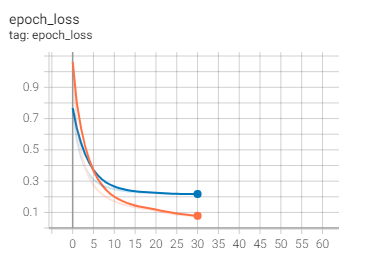

In [ ]:
def predict(input_sentence):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to decoder
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predicted_out,state_h,state_c=model.layers[1](dec_input,states)
            pass the predicted_out to the dense layer
            update the states=[state_h,state_c]
            And get the index of the word with maximum probability of the dense layer output, using the tokenizer(word index) get the word and then store it in a string.
            Update the input_to_decoder with current predictions
    F. Return the predicted sentence
    '''
    pred_sent = []
    sent = ita_tokenizer.texts_to_sequences([input_sentence])
    sent = pad_sequences(sent, maxlen=maxlen, padding='post')
    #print(sent, len(sent))
    enc_op, state_h, state_c = model.layers[0](sent)
    
    encoder_states = [state_h, state_c]

    target_word=np.zeros((1,1))
    target_word[0,0]=1
    
    stop = False
    # k = 0
    
    while not stop:    
        dec_op, state_h, state_c = model.layers[1](target_word, encoder_states)
        encoder_states = [state_h, state_c]
        dense_op = model.layers[2](dec_op)
        word_id = np.argmax(dense_op, axis=-1)[0][0]
        #print(word_id)
        target_word = word_id.reshape(1,1)
        word = eng_tokenizer.index_word.get(word_id)
        if word == '<end>':
            stop = True
        else:
            pred_sent.append(str(word))    
    return ' '.join(pred_sent)


In [ ]:
sam = validation['italian_inp'].values[1]
sam_targ = validation['english_out'].values[1]

In [ ]:
# Sample prediction
sam_op = predict(sam)
print("Italian inp: ", sam)
print("machine op: ", sam_op)
print("target op: ", sam_targ[0:-6])

Italian inp:  <start> beve del tè verde <end>
machine op:  do you drink green tea
target op:  do you drink green tea


In [ ]:
from nltk.translate import bleu_score

test_data = validation.sample(1000)
test_data_ita = test_data['italian_inp'].values
test_data_eng_in = test_data['english_inp'].values
test_data_eng_out = test_data['english_out'].values

blue_scores = []
for i in tqdm(range(len(test_data_ita))):
    eng_predicted = predict(test_data_ita[i])
    score = bleu_score.sentence_bleu([test_data_eng_out[i][0:-6].split()], eng_predicted[0:-6].split())
    blue_scores.append(score)

print(f"\nAvg BLEU Score for 1000 samples: {np.round(np.mean(blue_scores), 4)}")

100%|██████████| 1000/1000 [01:00<00:00, 16.48it/s]


Avg BLEU Score for 1000 samples: 0.2602


For simple encoder-decoder model,
Avg. BLEU score = 0.2602 (For 1000 samples)

## Task -2: Including Attention mechanism

1. Using the preprocessed data from Task-1

2. Implement an Encoder and Decoder architecture with  
attention

    * Encoder   - with 1 layer LSTM <br>
    * Decoder   - with 1 layer LSTM<br>
    * attention 
3. In Global attention, we have 3 types of scoring functions.>

    * In model 1 we will implemnt "dot" score function
    * In model 2 we will implemnt "general" score function
    * In model 3 we will implemnt "concat" score function.<br>
    

### <font color='blue'>**Implement custom encoder decoder and attention layers**</font>

In [ ]:
import os
def create_directories(model_name):
    if str(model_name) not in os.listdir():
        os.mkdir(model_name)
        os.mkdir(model_name+'/saved_models')
        os.mkdir(model_name+'/logs')
        print(f"saved_models, logs directories created for {model_name}")

<font color='blue'>**Encoder**</font>

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import TimeDistributed

In [ ]:
class Encoder(tf.keras.Model):
    '''
    Encoder model -- That takes a input sequence and returns output sequence
    '''

    def __init__(self,inp_vocab_size,embedding_size,lstm_size,input_length):

        # Initializing parameters
        super(Encoder, self).__init__()
        self.inp_vocab_size = inp_vocab_size
        self.embedding_size = embedding_size
        self.lstm_size = lstm_size
        self.input_length = input_length

        #Initialize Embedding layer
        self.encoder_embedding = Embedding(input_dim = self.inp_vocab_size, 
                                           output_dim = self.embedding_size, 
                                           input_length = self.input_length)
        #Intialize Encoder LSTM layer
        self.encoder_lstm = LSTM(units = self.lstm_size, return_sequences=True, return_state=True)

    def call(self,input_sequence,states):
        '''
          This function takes a sequence input and the initial states of the encoder.
          Pass the input_sequence input to the Embedding layer, Pass the embedding layer ouput to encoder_lstm
          returns -- All encoder_outputs, last time steps hidden and cell state
        '''
        emb_op = self.encoder_embedding(input_sequence)
        enc_out, enc_h, enc_c = self.encoder_lstm(emb_op, states)
        return enc_out, enc_h, enc_c
    
    def initialize_states(self,batch_size):
        '''
        Given a batch size it will return intial hidden state and intial cell state.
        If batch size is 32- Hidden state is zeros of size [32,lstm_units], cell state zeros is of size [32,lstm_units]
        '''
        initial_h = tf.zeros(shape = (batch_size, self.lstm_size))
        initial_c = tf.zeros(shape = (batch_size, self.lstm_size))
        states = [initial_h, initial_c]
        return states


<font color='blue'>**Attention**</font>

In [ ]:
class Attention(tf.keras.layers.Layer):
  '''
    Class calculates score based on the scoring_function using Bahdanu attention mechanism.
  '''
  def __init__(self,scoring_function, att_units):

        super(Attention, self).__init__()
        self.scoring_function = scoring_function
        self.att_units = att_units
        #self.attention_weights
        #self.context_vector
        
        # Please go through the reference notebook and research paper to complete the scoring functions
    
        if self.scoring_function =='dot':
            # Intialize variables needed for Dot score function here
            self.V = tf.keras.layers.Dense(1)
        
        if scoring_function == 'general':
        # Intialize variables needed for General score function here
            w_init = tf.keras.initializers.RandomNormal()
            self.w = tf.Variable(
                initial_value= w_init(shape=(self.att_units, self.att_units),dtype='float32'),
                trainable = True)
        
        elif scoring_function == 'concat':
        # Intialize variables needed for Concat score function here
            w1_init = tf.keras.initializers.RandomNormal()
            w2_init = tf.keras.initializers.RandomNormal()
            v_init = tf.keras.initializers.RandomNormal()
            self.k = 16
            
            self.w1 = tf.Variable(
                initial_value= w1_init(shape=(self.att_units, self.k),dtype='float32'),
                trainable = True)
            
            self.w2 = tf.Variable(
                initial_value= w2_init(shape=(self.att_units, self.k),dtype='float32'),
                trainable = True)
            
            self.v = tf.Variable(
                initial_value= w2_init(shape=(1, self.k),dtype='float32'),
                trainable = True)
  
  def call(self,decoder_hidden_state,encoder_output):
    '''
      Attention mechanism takes two inputs current step -- decoder_hidden_state and all the encoder_outputs.
      * Based on the scoring function we will find the score or similarity between decoder_hidden_state and encoder_output.
        Multiply the score function with your encoder_outputs to get the context vector.
        Function returns context vector and attention weights(softmax - scores)
    '''
    
    scores = []


    if self.scoring_function == 'dot':
        # Implement Dot score function here
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        for b_id in range(encoder_output.shape[0]): # batch_sample
            enc_ts = encoder_output[b_id, :, :]
            dec_hs = decoder_hidden_state[b_id, :, :]
            #print(enc_ts.shape, dec_hs.shape)
            score = tf.tensordot(enc_ts, tf.transpose(dec_hs), axes=1)
            scores.append(score)

        self.attention_weights = self.V(tf.convert_to_tensor(scores))
        self.attention_weights = tf.nn.softmax(scores, axis=1)
        # print(self.attention_weights.shape)
        self.context_vector = self.attention_weights * encoder_output
        # print(self.context_vector.shape)
        self.context_vector = tf.reduce_sum(self.context_vector, axis=1)
        # print(self.context_vector.shape)
        return self.context_vector, self.attention_weights

    elif self.scoring_function == 'general':
        # Implement General score function here
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        for b_id in range(encoder_output.shape[0]): # batch_sample
            enc_ts = encoder_output[b_id, :, :]
            dec_hs = decoder_hidden_state[b_id, :, :]
            score = tf.tensordot(enc_ts, self.w, axes=1)
            score = tf.tensordot(score, tf.transpose(dec_hs), axes=1)
            scores.append(score)

        self.attention_weights = tf.convert_to_tensor(scores)
        self.attention_weights = tf.nn.softmax(scores, axis=1)
        # print(self.attention_weights.shape)
        self.context_vector = self.attention_weights * encoder_output
        # print(self.context_vector.shape)
        self.context_vector = tf.reduce_sum(self.context_vector, axis=1)
        # print(self.context_vector.shape)
        return self.context_vector, self.attention_weights
    
    elif self.scoring_function == 'concat':
        # Implement General score function here
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, 1)
        for b_id in range(encoder_output.shape[0]): # batch_sample
            enc_ts = encoder_output[b_id, :, :]
            dec_hs = decoder_hidden_state[b_id, :, :]
            dec_w1 = tf.tensordot(dec_hs, self.w1, axes=1)
            enc_w2 = tf.tensordot(enc_ts, self.w2, axes=1)
            tanh_op = tf.math.tanh(tf.math.add(dec_w1, enc_w2))
            score = tf.tensordot(tanh_op, tf.transpose(self.v), axes=1)
            scores.append(score)

        self.attention_weights = tf.convert_to_tensor(scores)
        self.attention_weights = tf.nn.softmax(scores, axis=1)
        # print(self.attention_weights.shape)
        self.context_vector = self.attention_weights * encoder_output
        # print(self.context_vector.shape)
        self.context_vector = tf.reduce_sum(self.context_vector, axis=1)
        # print(self.context_vector.shape)
        return self.context_vector, self.attention_weights        

<font color='blue'>**OneStepDecoder**</font>

In [ ]:
class One_Step_Decoder(tf.keras.Model):
  def __init__(self,tar_vocab_size, embedding_dim, input_length, dec_units ,score_func ,att_units):

    super(One_Step_Decoder, self).__init__()
    self.tar_vocab_size = tar_vocab_size
    self.embedding_dim = embedding_dim
    self.input_length = input_length
    self.dec_units = dec_units
    self.score_func = score_func
    self.att_units = att_units
    
    # Initialize decoder embedding layer, LSTM and any other objects needed
    self.osd_embedding = Embedding(input_dim = self.tar_vocab_size, 
                                   output_dim = self.embedding_dim,
                                   input_length = self.input_length,)
    
    self.osd_lstm = LSTM(self.dec_units, return_sequences=True,
                         return_state=True)
    
    self.attention = Attention(self.score_func, self.att_units)

    self.dense = Dense(self.tar_vocab_size)

  def call(self,input_to_decoder, encoder_output, state_h,state_c):
    '''
        One step decoder mechanism step by step:
      A. Pass the input_to_decoder to the embedding layer and then get the output(batch_size,1,embedding_dim)
      B. Using the encoder_output and decoder hidden state, compute the context vector.
      C. Concat the context vector with the step A output
      D. Pass the Step-C output to LSTM/GRU and get the decoder output and states(hidden and cell state)
      E. Pass the decoder output to dense layer(vocab size) and store the result into output.
      F. Return the states from step D, output from Step E, attention weights from Step -B
    '''

    # Embedding output
    emb_out = self.osd_embedding(input_to_decoder)
    # Context vector and attention_weights 
    context_vect, att_weights = self.attention(state_h, encoder_output)
    # Creatig input to lstm = concat(emb_out, context_vect)
    ip_concat = tf.concat([tf.expand_dims(context_vect,1),emb_out], -1)
    # Decoder lstm
    dec_op, dec_h, dec_c = self.osd_lstm(ip_concat, [state_h, state_c])
    # Dense
    dense_op = self.dense(dec_op)
    dense_op = tf.reduce_sum(dense_op, axis=1)
    # print('-'*30)
    # print(f"dense_op: {dense_op.shape}")
    # print(f"dec_h: {dec_h.shape}")
    # print(f"dec_c: {dec_c.shape}")
    # print(f"att_weights: {att_weights.shape}")
    # print(f"context_vect: {context_vect.shape}")

    return dense_op, dec_h, dec_c,  att_weights, context_vect

<font color='blue'>**Decoder**</font>

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        #Intialize necessary variables and create an object from the class onestepdecoder
        super(Decoder, self).__init__()
        self.out_vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.os_decoder = One_Step_Decoder(self.out_vocab_size, self.embedding_dim, self.input_length,
                                           self.dec_units, self.score_fun, self.att_units)


    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state):

        #Initialize an empty Tensor array, that will store the outputs at each and every time step
        #Create a tensor array as shown in the reference notebook
        outputs = tf.TensorArray(tf.float32, size=25, name='outputs')
        #Iterate till the length of the decoder input
        for tstep in range(25):
            # Call onestepdecoder for each token in decoder_input
            dense_output, decoder_hidden_state,decoder_cell_state, _, _ = self.os_decoder(input_to_decoder[:, tstep:tstep+1], encoder_output,
                                                                          decoder_hidden_state, decoder_cell_state)
            # Store the output in tensorarray
            outputs = outputs.write(tstep, dense_output)
        # Return the tensor array
        outputs = tf.transpose(outputs.stack(), [1,0,2])
        return outputs
        
    

<font color='blue'>**Encoder Decoder model**</font>

In [ ]:
class encoder_decoder(tf.keras.Model):
  def __init__(self, inp_vocab_size, enc_emb_size, enc_lstm_size, enc_input_length, 
               out_vocab_size, dec_emb_size, dec_lstm_size, dec_input_length,
               batch_size, score_fun, att_units):
    
    #Intialize objects from encoder decoder
    super(encoder_decoder, self).__init__()

    self.inp_vocab_size    =   inp_vocab_size
    self.enc_emb_size      =   enc_emb_size
    self.enc_lstm_size     =   enc_lstm_size
    self.enc_input_length  =   enc_input_length
    self.out_vocab_size    =   out_vocab_size
    self.dec_emb_size      =   dec_emb_size
    self.dec_lstm_size     =   dec_lstm_size
    self.dec_input_length  =   dec_input_length
    self.batch_size        =   batch_size
    self.score_fun         =   score_fun
    self.att_units         =   att_units

    self.encoder = Encoder(inp_vocab_size = self.inp_vocab_size,
                           embedding_size = self.enc_emb_size,
                           lstm_size      = self.enc_lstm_size,
                           input_length   = self.enc_input_length)
    
    self.decoder = Decoder(out_vocab_size = self.out_vocab_size,
                           embedding_dim  = self.dec_emb_size,
                           input_length   = self.dec_input_length,
                           dec_units      = self.dec_lstm_size,
                           score_fun      = self.score_fun,
                           att_units      = self.att_units)
  
    
  def call(self,data):
    #Intialize encoder states, Pass the encoder_sequence to the encoder layer
    enc_input, dec_input = data[0], data[1]
    #print(f"encoder_input shape: {enc_input.shape} ; decoder_input shape: {dec_input.shape}")
    initial_states = self.encoder.initialize_states(self.batch_size)
    enc_op, enc_h, enc_c = self.encoder(enc_input, initial_states)
    # Decoder initial states are encoder final states, Initialize it accordingly
    # Pass the decoder sequence,encoder_output,decoder states to Decoder
    dec_op = self.decoder(dec_input, enc_op, enc_h, enc_c)
    # return the decoder output
    return dec_op

<font color='blue'>**Custom loss function**</font>

In [ ]:
#https://www.tensorflow.org/tutorials/text/image_captioning#model
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

def loss_function(real, pred):
    """ Custom loss function that will not consider the loss for padded zeros.
    why are we using this, can't we use simple sparse categorical crossentropy?
    Yes, you can use simple sparse categorical crossentropy as loss like we did in task-1. But in this loss function we are ignoring the loss
    for the padded zeros. i.e when the input is zero then we do not need to worry what the output is. This padded zeros are added from our end
    during preprocessing to make equal length for all the sentences.

    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

## <font color='blue'>**Inference**</font>

<font color='blue'>**Plot attention weights**</font>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def plot_attention(att_weights, ip_sent, out_sent):
    #Refer: https://www.tensorflow.org/tutorials/text/nmt_with_attention#translate
    
    xlabels = ip_sent.split()
    ylabels = out_sent.split()

    fig, ax = plt.subplots()
    sns.heatmap(att_weights, cmap='BuPu')
    plt.yticks(np.arange(len(ylabels)) + .5, labels=ylabels, rotation=0)
    plt.xticks(np.arange(len(xlabels)) + .5, labels=xlabels, rotation=45)
    ax.xaxis.tick_top()
    plt.show()

<font color='blue'>**Predict the sentence translation**</font>

In [ ]:
def predict(input_sentence, model, plot_att=False):

    '''
    A. Given input sentence, convert the sentence into integers using tokenizer used earlier
    B. Pass the input_sequence to encoder. we get encoder_outputs, last time step hidden and cell state
    C. Initialize index of <start> as input to decoder. and encoder final states as input_states to onestepdecoder.
    D. till we reach max_length of decoder or till the model predicted word <end>:
            predictions, input_states, attention_weights = model.layers[1].onestepdecoder(input_to_decoder, encoder_output, input_states)
            Save the attention weights
            And get the word using the tokenizer(word index) and then store it in a string.
    E. Call plot_attention(#params)
    F. Return the predicted sentence
    '''
    len_sent = len(input_sentence.split())
    sent = ita_tokenizer.texts_to_sequences([input_sentence])
    sent = pad_sequences(sent, maxlen = maxlen, padding='post')
    states = model.layers[0].initialize_states(1)
    enc_op, enc_h, enc_c = model.layers[0](sent, states)
    
    target_word=np.zeros((1,1))
    target_word[0,0]=1
    
    stop = False

    att_matrix = []
    pred_sent = []
    while not stop:    
        dense_op, dec_h, dec_c,  att_weights, context_vect = model.layers[1].os_decoder(target_word, enc_op, enc_h, enc_c)
        enc_h, enc_c = dec_h, dec_c
        att_wts = tf.squeeze(att_weights).numpy()
        #print(att_wts)
        #att_wts = np.flip(att_wts)[0:len_sent]
        att_wts = att_wts[0:len_sent]
        att_matrix.append(att_wts)
        word_id = np.argmax(dense_op, axis=-1)[0]
        target_word = word_id.reshape(1,1)
        word = eng_tokenizer.index_word.get(word_id)
        if word == '<end>' or len(pred_sent) > len_sent + 3:
            stop = True
        pred_sent.append(str(word))

    pred_sent = ' '.join(pred_sent)
    
    if plot_att:
        plot_attention(att_matrix, input_sentence, pred_sent)

    return pred_sent

<font color='blue'>**Calculate BLEU score**</font>

In [ ]:
#Create an object of your custom model.
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

#Sample example
# from nltk.translate import bleu_score

# # Plotting attention weights for 4 test samples
# for i in tqdm(range(4)):
#     eng_predicted = predict(test_data_ita[i], model_dot, plot_attention = True)

# # BLEU score for 1000 test samples
# blue_scores = []
# for i in tqdm(range(len(test_data_ita))):
#     eng_predicted = predict(test_data_ita[i], model_dot)
#     score = bleu_score.sentence_bleu([test_data_eng_out[i][0:-6].split()], eng_predicted[0:-6].split())
#     blue_scores.append(score)

# print(f"\nAvg BLEU Score for 1000 samples: {np.round(np.mean(blue_scores), 4)}")

In [ ]:
from nltk.translate import bleu_score

In [ ]:
test_data = validation.sample(1000)
test_data_ita = test_data['italian_inp'].values
test_data_eng_in = test_data['english_inp'].values
test_data_eng_out = test_data['english_out'].values

<font color='blue'>**Training**</font>

<font color='blue'>**Dot scoring function**</font>

In [ ]:
#Compile and train your model on dot scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os

def create_directories(model_name):
    if str(model_name) not in os.listdir():
        os.mkdir(model_name)
        os.mkdir(model_name+'/saved_models')
        os.mkdir(model_name+'/logs')
        print(f"saved_models, logs directories created for {model_name}")

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.9

create_directories('model_dot')
save_path = '/content/model_dot/saved_models/{epoch:02d}'
log_path = '/content/model_dot/logs'

#Defining callbacks
lr = LearningRateScheduler(scheduler)
stopper = EarlyStopping(monitor='val_loss', patience=4, mode='min')
saver = ModelCheckpoint(save_path, save_best_only = True)
tb = TensorBoard(log_path)

callbacks = [saver, tb]

saved_models, logs directories created for model_dot


In [ ]:
# Model Params General Scoring Function

inp_vocab_size   = ita_vocab_len
enc_emb_size     = 50
enc_lstm_size    = 64
enc_input_length = 25
out_vocab_size   = eng_vocab_len
dec_emb_size     = 100
dec_lstm_size    = 64
dec_input_length = 25
batch_size       = 256
score_fun        = 'dot'
att_units        = 64


model_dot = encoder_decoder(inp_vocab_size, enc_emb_size, enc_lstm_size,
                            enc_input_length, out_vocab_size, dec_emb_size,
                            dec_lstm_size, dec_input_length, batch_size,
                            score_fun, att_units)



model_dot.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = loss_function)

In [ ]:
# Creating train and validation datasets
train1 = tf.data.Dataset.from_tensor_slices((ita_inp, eng_inp))
train2 = tf.data.Dataset.from_tensor_slices(eng_out)
train_ds = tf.data.Dataset.zip((train1,train2))
train_steps = int(len(train_ds)//batch_size)
train_ds = train_ds.batch(batch_size, drop_remainder=True).repeat()

val1 = tf.data.Dataset.from_tensor_slices((ita_inp_val, eng_inp_val))
val2 = tf.data.Dataset.from_tensor_slices(eng_out_val)
val_ds = tf.data.Dataset.zip((val1,val2))
val_steps = int(len(val_ds)//batch_size)
val_ds = val_ds.batch(batch_size, drop_remainder=True).repeat()

In [ ]:
# Training the model
hist_model_dot = model_dot.fit(train_ds, epochs=35, batch_size=batch_size, steps_per_epoch=train_steps,
                 validation_data=val_ds, validation_steps=val_steps,
                 callbacks = callbacks)

Epoch 1/35
1105/1105 [==============================] - 1014s 569ms/step - loss: 1.3357 - val_loss: nan
Epoch 2/35
1105/1105 [==============================] - 547s 495ms/step - loss: 0.9816 - val_loss: nan
Epoch 3/35
1105/1105 [==============================] - 548s 496ms/step - loss: 0.8368 - val_loss: nan
Epoch 4/35
1105/1105 [==============================] - 549s 497ms/step - loss: 0.7349 - val_loss: nan
Epoch 5/35
1105/1105 [==============================] - 551s 499ms/step - loss: 0.6537 - val_loss: nan
Epoch 6/35
1105/1105 [==============================] - 553s 501ms/step - loss: 0.5864 - val_loss: nan
Epoch 7/35
1105/1105 [==============================] - 549s 497ms/step - loss: 0.5273 - val_loss: nan
Epoch 8/35
1105/1105 [==============================] - 550s 497ms/step - loss: 0.4771 - val_loss: nan
Epoch 9/35
1105/1105 [==============================] - 550s 498ms/step - loss: 0.4345 - val_loss: nan
Epoch 10/35
1105/1105 [==============================] - 549s 497ms/step

In [ ]:
model_dot.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1366840   
                                                                 
 decoder (Decoder)           multiple                  2219796   
                                                                 
Total params: 3,586,636
Trainable params: 3,586,636
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Sample prediction
sam = validation['italian_inp'].values[111]
sam_targ = validation['english_out'].values[111]
sam_op = predict(sam, model_dot)
print("Italian inp: ", sam)
print("machine op: ", sam_op)
print("target op: ", sam_targ[0:-6])

Italian inp:  <start> le mie scarpe sono troppo piccole <end>
machine op:  my shoes are too small <end>
target op:  my shoes are too small


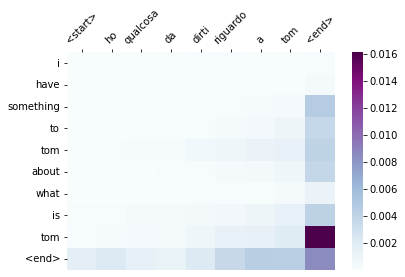

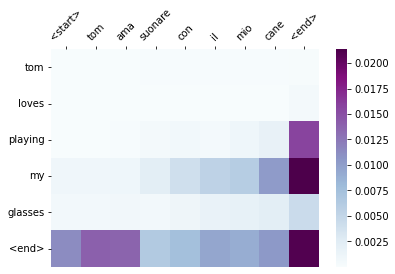

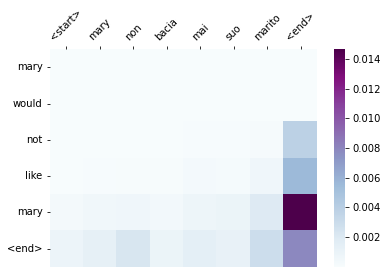

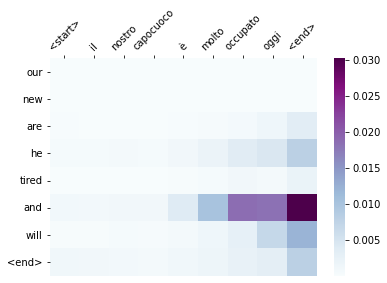

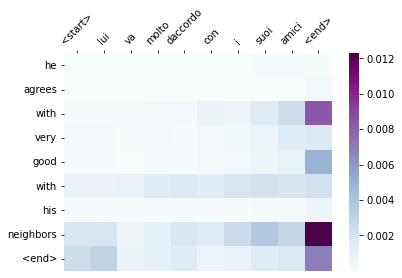

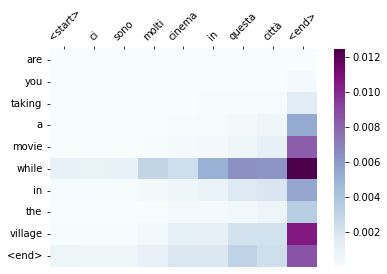

In [ ]:
# Plotting attention weights for 4 test samples
for i in (range(10, 16)):
    eng_predicted = predict(test_data_ita[i], model_dot, plot_att = True)

In [ ]:
# BLEU score for 1000 test samples
blue_scores = []
for i in tqdm(range(len(test_data_ita))):
    eng_predicted = predict(test_data_ita[i], model_dot)
    score = bleu_score.sentence_bleu([test_data_eng_out[i][0:-6].split()], eng_predicted[0:-6].split())
    blue_scores.append(score)

print("For dot scoring function model - ")
print(f"\nAvg BLEU Score for 1000 samples: {np.round(np.mean(blue_scores), 4)}")

100%|██████████| 1000/1000 [01:35<00:00, 10.42it/s]

For dot scoring function model - 

Avg BLEU Score for 1000 samples: 0.4468


<font color='blue'>**Repeat the same steps for General scoring function**</font>

In [ ]:
#Compile and train your model on general scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os

def create_directories(model_name):
    if str(model_name) not in os.listdir():
        os.mkdir(model_name)
        os.mkdir(model_name+'/saved_models')
        os.mkdir(model_name+'/logs')
        print(f"saved_models, logs directories created for {model_name}")

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.9

create_directories('model_2_general')
save_path = '/content/model_2_general/saved_models/{epoch:02d}'
log_path = '/content/model_2_general/logs'

#Defining callbacks
lr = LearningRateScheduler(scheduler)
stopper = EarlyStopping(monitor='val_loss', patience=4, mode='min')
saver = ModelCheckpoint(save_path, save_best_only = True)
tb = TensorBoard(log_path)

callbacks = [saver, tb]

saved_models, logs directories created for model_2_general


In [ ]:
# Model Params General Scoring Function

inp_vocab_size   = ita_vocab_len
enc_emb_size     = 50
enc_lstm_size    = 64
enc_input_length = 25
out_vocab_size   = eng_vocab_len
dec_emb_size     = 100
dec_lstm_size    = 64
dec_input_length = 25
batch_size       = 256
score_fun        = 'general'
att_units        = 64


model_general = encoder_decoder(inp_vocab_size, enc_emb_size, enc_lstm_size,
                            enc_input_length, out_vocab_size, dec_emb_size,
                            dec_lstm_size, dec_input_length, batch_size,
                            score_fun, att_units)



model_general.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = loss_function)

In [ ]:
# Creating train and validation datasets
train1 = tf.data.Dataset.from_tensor_slices((ita_inp, eng_inp))
train2 = tf.data.Dataset.from_tensor_slices(eng_out)
train_ds = tf.data.Dataset.zip((train1,train2))
train_steps = int(len(train_ds)//batch_size)
train_ds = train_ds.batch(batch_size, drop_remainder=True).repeat()

val1 = tf.data.Dataset.from_tensor_slices((ita_inp_val, eng_inp_val))
val2 = tf.data.Dataset.from_tensor_slices(eng_out_val)
val_ds = tf.data.Dataset.zip((val1,val2))
val_steps = int(len(val_ds)//batch_size)
val_ds = val_ds.batch(batch_size, drop_remainder=True).repeat()

In [ ]:
# Training the model
hist_model_general = model_general.fit(train_ds, epochs=35, batch_size=batch_size,
                                       steps_per_epoch=train_steps,
                                       validation_data=val_ds,
                                       validation_steps=val_steps,
                                       callbacks=callbacks)

Epoch 1/35
1105/1105 [==============================] - 1338s 874ms/step - loss: 1.3128 - val_loss: nan
Epoch 2/35
1105/1105 [==============================] - 877s 794ms/step - loss: 0.9548 - val_loss: nan
Epoch 3/35
1105/1105 [==============================] - 875s 792ms/step - loss: 0.8059 - val_loss: nan
Epoch 4/35
1105/1105 [==============================] - 876s 793ms/step - loss: 0.7027 - val_loss: nan
Epoch 5/35
1105/1105 [==============================] - 872s 789ms/step - loss: 0.6182 - val_loss: nan
Epoch 6/35
1105/1105 [==============================] - 870s 787ms/step - loss: 0.5436 - val_loss: nan
Epoch 7/35
1105/1105 [==============================] - 873s 790ms/step - loss: 0.4744 - val_loss: nan
Epoch 8/35
1105/1105 [==============================] - 867s 785ms/step - loss: 0.4088 - val_loss: nan
Epoch 9/35
1105/1105 [==============================] - 865s 783ms/step - loss: 0.3498 - val_loss: nan
Epoch 10/35
1105/1105 [==============================] - 876s 793ms/step

In [ ]:
model_general.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1366840   
                                                                 
 decoder (Decoder)           multiple                  2223890   
                                                                 
Total params: 3,590,730
Trainable params: 3,590,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Sample prediction
sam = validation['italian_inp'].values[0]
sam_targ = validation['english_out'].values[0]
sam_op = predict(sam, model_general)
print("Italian inp: ", sam)
print("machine op: ", sam_op)
print("target op: ", sam_targ[0:-6])

Italian inp:  <start> noi stiamo perdendo <end>
machine op:  we are losing <end>
target op:  we are losing


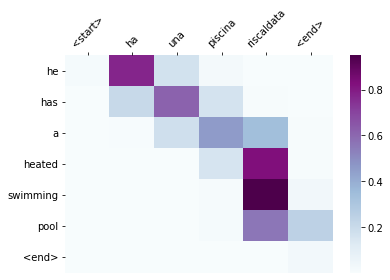

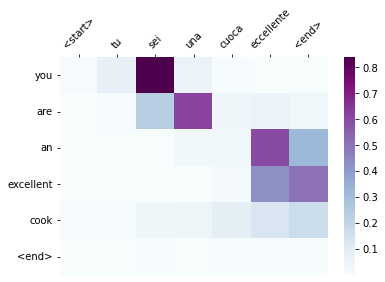

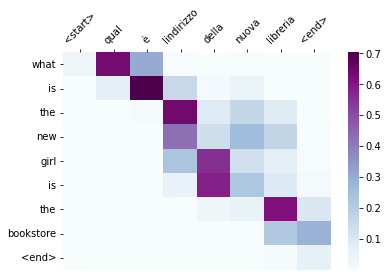

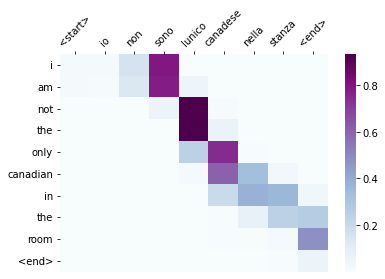

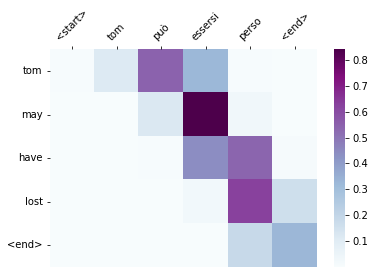

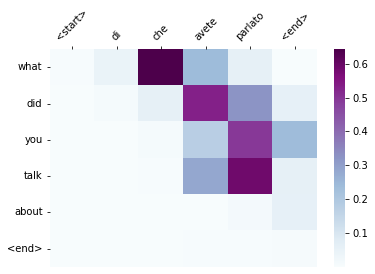

In [ ]:
# Plotting attention weights for 4 test samples
for i in (range(10,16)):
    eng_predicted = predict(test_data_ita[i], model_general, plot_att = True)

In [ ]:
# BLEU score for 1000 test samples
blue_scores = []
for i in tqdm(range(len(test_data_ita))):
    eng_predicted = predict(test_data_ita[i], model_general)
    score = bleu_score.sentence_bleu([test_data_eng_out[i][0:-6].split()], eng_predicted[0:-6].split())
    blue_scores.append(score)

print("For general scoring function model - ")
print(f"\nAvg BLEU Score for 1000 samples: {np.round(np.mean(blue_scores), 4)}")

100%|██████████| 1000/1000 [00:55<00:00, 17.91it/s]

For general scoring function model - 

Avg BLEU Score for 1000 samples: 0.559


<font color='blue'>**Repeat the same steps for Concat scoring function**</font>

In [ ]:
#Compile and train your model on concat scoring function.
# Visualize few sentences randomly in Test data
# Predict on 1000 random sentences on test data and calculate the average BLEU score of these sentences.
# https://www.nltk.org/_modules/nltk/translate/bleu_score.html

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os

def create_directories(model_name):
    if str(model_name) not in os.listdir():
        os.mkdir(model_name)
        os.mkdir(model_name+'/saved_models')
        os.mkdir(model_name+'/logs')
        print(f"saved_models, logs directories created for {model_name}")

def scheduler(epoch, lr):
    if epoch < 20:
        return lr
    else:
        return lr * 0.9

create_directories('model_2_concat')
save_path = '/content/model_2_concat/saved_models/{epoch:02d}'
log_path = '/content/model_2_concat/logs'

#Defining callbacks
lr = LearningRateScheduler(scheduler)
stopper = EarlyStopping(monitor='val_loss', patience=4, mode='min')
saver = ModelCheckpoint(save_path, save_best_only = True)
tb = TensorBoard(log_path)

callbacks = [saver, tb]

saved_models, logs directories created for model_2_concat


In [ ]:
# Model Params Concat Scoring Function

inp_vocab_size   = ita_vocab_len
enc_emb_size     = 50
enc_lstm_size    = 64
enc_input_length = 25
out_vocab_size   = eng_vocab_len
dec_emb_size     = 100
dec_lstm_size    = 64
dec_input_length = 25
batch_size       = 256
score_fun        = 'concat'
att_units        = 64


model_concat = encoder_decoder(inp_vocab_size, enc_emb_size, enc_lstm_size,
                            enc_input_length, out_vocab_size, dec_emb_size,
                            dec_lstm_size, dec_input_length, batch_size,
                            score_fun, att_units)



model_concat.compile(optimizer = tf.keras.optimizers.Adam(),
                  loss = loss_function)

In [ ]:
# Creating train and validation datasets
train1 = tf.data.Dataset.from_tensor_slices((ita_inp, eng_inp))
train2 = tf.data.Dataset.from_tensor_slices(eng_out)
train_ds = tf.data.Dataset.zip((train1,train2))
train_steps = int(len(train_ds)//batch_size)
train_ds = train_ds.batch(batch_size, drop_remainder=True).repeat()

val1 = tf.data.Dataset.from_tensor_slices((ita_inp_val, eng_inp_val))
val2 = tf.data.Dataset.from_tensor_slices(eng_out_val)
val_ds = tf.data.Dataset.zip((val1,val2))
val_steps = int(len(val_ds)//batch_size)
val_ds = val_ds.batch(batch_size, drop_remainder=True).repeat()

In [ ]:
# Training the model
hist_model_concat = model_concat.fit(train_ds, epochs=35, batch_size=batch_size,
                                     steps_per_epoch=train_steps,
                                     validation_data=val_ds,
                                     validation_steps=val_steps,
                                     callbacks = callbacks)

Epoch 1/35
1105/1105 [==============================] - 2385s 1s/step - loss: 1.3416 - val_loss: nan
Epoch 2/35
1105/1105 [==============================] - 1475s 1s/step - loss: 0.9724 - val_loss: nan
Epoch 3/35
1105/1105 [==============================] - 1472s 1s/step - loss: 0.8021 - val_loss: nan
Epoch 4/35
1105/1105 [==============================] - 1475s 1s/step - loss: 0.6930 - val_loss: nan
Epoch 5/35
1105/1105 [==============================] - 1462s 1s/step - loss: 0.6067 - val_loss: nan
Epoch 6/35
1105/1105 [==============================] - 1459s 1s/step - loss: 0.5315 - val_loss: nan
Epoch 7/35
1105/1105 [==============================] - 1467s 1s/step - loss: 0.4629 - val_loss: nan
Epoch 8/35
1105/1105 [==============================] - 1472s 1s/step - loss: 0.3994 - val_loss: nan
Epoch 9/35
1105/1105 [==============================] - 1468s 1s/step - loss: 0.3432 - val_loss: nan
Epoch 10/35
1105/1105 [==============================] - 1457s 1s/step - loss: 0.2968 - val

In [ ]:
model_concat.summary()

Model: "encoder_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  1366840   
                                                                 
 decoder (Decoder)           multiple                  2221858   
                                                                 
Total params: 3,588,698
Trainable params: 3,588,698
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Sample prediction
sam = validation['italian_inp'].values[0]
sam_targ = validation['english_out'].values[0]
sam_op = predict(sam, model_concat)
print("Italian inp: ", sam)
print("machine op: ", sam_op)
print("target op: ", sam_targ[0:-6])

Italian inp:  <start> noi stiamo perdendo <end>
machine op:  we are losing <end>
target op:  we are losing


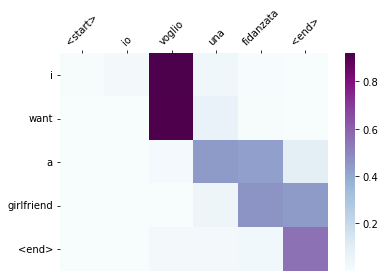

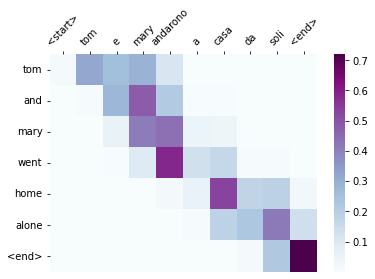

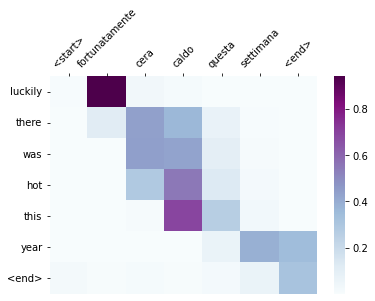

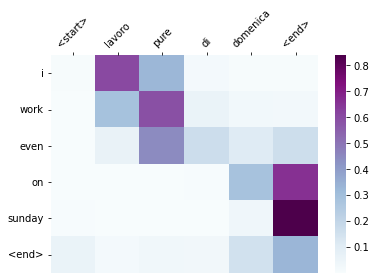

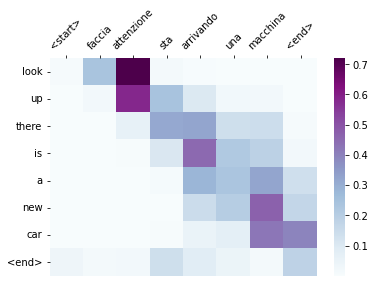

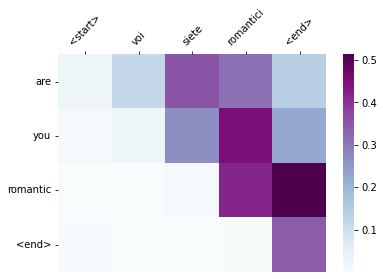

In [ ]:
# Plotting attention weights for 4 test samples
for i in (range(10,16)):
    eng_predicted = predict(test_data_ita[i], model_concat, plot_att = True)

In [ ]:
# BLEU score for 1000 test samples
blue_scores = []
for i in tqdm(range(len(test_data_ita))):
    eng_predicted = predict(test_data_ita[i], model_concat)
    score = bleu_score.sentence_bleu([test_data_eng_out[i][0:-6].split()], eng_predicted[0:-6].split())
    blue_scores.append(score)

print("For concat scoring function model - ")
print(f"\nAvg BLEU Score for 1000 samples: {np.round(np.mean(blue_scores), 4)}")

100%|██████████| 1000/1000 [01:26<00:00, 11.51it/s]

For concat scoring function model - 

Avg BLEU Score for 1000 samples: 0.5415


In [3]:
# Write your observations on each of the scoring function
from prettytable import PrettyTable

tab = PrettyTable(field_names = ["Attention Score Type", "Loss", "Validation BLEU Score"])
tab.add_rows([["No attention", 0.0745, 0.2602],
             ["Dot Score", 0.1147, 0.4468], 
             ["General Score", 0.0671, 0.559],
             ["Concat Score", 0.0683, 0.5415]])
print("Models Summary: ")
print(tab)

Models Summary: 
+----------------------+--------+-----------------------+
| Attention Score Type |  Loss  | Validation BLEU Score |
+----------------------+--------+-----------------------+
|     No attention     | 0.0745 |         0.2602        |
|      Dot Score       | 0.1147 |         0.4468        |
|    General Score     | 0.0671 |         0.559         |
|     Concat Score     | 0.0683 |         0.5415        |
+----------------------+--------+-----------------------+


**Observations -**

1. Encoder-Decoder models with Attention showed significant improvement in the BLEU score over non-attention model.
2. We used three scoring methods (Dot, General and Concat) for attention models.
3. Comparison of BLEU score for scoring methods : General Score > Concat Score > Dot Score
4. General Score and Concat Score Attention models showed similar performance. They are better than than Dot Scoring attention since they have more no of trainable attention parameters. 
5. In Concat Scoring, value of K could be increased to increase no of trainable attention parameters which might increase the performance of the model. 